This script is mostly derived from the tutorial scripts. It imports and reduces a phantom model, saving the result in a seperate directory.

In [1]:
import magritte.setup as setup                # Model setup
import magritte.core  as magritte             # Core functionality
import numpy          as np                   # Data structures
import warnings                               # Hide warnings
warnings.filterwarnings('ignore')             # especially for yt
import yt                                     # 3D plotting
import os

from tqdm          import tqdm                # Progress bars
from astropy       import constants, units    # Unit conversions
from scipy.spatial import Delaunay, cKDTree   # Finding neighbors
from yt.funcs      import mylog               # To avoid yt output 
mylog.setLevel(40)                            # as error messages

#plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

Create working directory

In [2]:
wdir = "/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/"
!mkdir -p $wdir

Define input files

In [3]:
input_file = os.path.join(wdir, 'model_Phantom_3D.ascii')   # Phantom snapshot
model_file = os.path.join(wdir, 'model_Phantom_3D.hdf5' )   # Resulting Magritte model
lamda_file = os.path.join(wdir, 'co.txt'                )   # Line data file

Download the model and line data

In [4]:
input_link = "https://owncloud.ster.kuleuven.be/index.php/s/6mCZjZ2erTsXq5Y/download"
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"
!wget $input_link --output-document $input_file
!wget $lamda_link --output-document $lamda_file

--2023-03-07 14:05:36--  https://owncloud.ster.kuleuven.be/index.php/s/6mCZjZ2erTsXq5Y/download
Resolving owncloud.ster.kuleuven.be (owncloud.ster.kuleuven.be)... 134.58.130.75
Connecting to owncloud.ster.kuleuven.be (owncloud.ster.kuleuven.be)|134.58.130.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388714637 (371M) [application/octet-stream]
Saving to: ‘/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/model_Phantom_3D.ascii’

/lhome/thomasc/Magr 100%[===================>] 370.71M  59.7MB/s    in 6.2s    

2023-03-07 14:05:42 (60.0 MB/s) - ‘/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/model_Phantom_3D.ascii’ saved [388714637/388714637]

--2023-03-07 14:05:43--  https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat
Resolving home.strw.leidenuniv.nl (home.strw.leidenuniv.nl)... 132.229.214.179
Connecting to home.strw.leidenuniv.nl (home.strw.leidenuniv.nl)|132.229.214.179|:443... connected.
HTTP request sent, awaiting response..

# Create model

The script below extracts the required data from the snapshot .ascii file.

In [5]:
# Read the Phantom ascii file
(x,y,z, h, rho, vx,vy,vz, u) = np.loadtxt(input_file, skiprows=14, usecols=(0,1,2,4,5,6,7,8,9), unpack=True)

# Constants that can be read from ascii file
velocity_cte = 2.9784608e+06
density_cte  = 5.9410314e-07
energy_cte   = 8.8712277e+12

keep = np.logical_and(h>0.0, rho>0.0)

# Exclude unphysical points and points with zero abundance
x   = x  [keep]
y   = y  [keep]
z   = z  [keep]
vx  = vx [keep]
vy  = vy [keep]
vz  = vz [keep]
u   = u  [keep]
rho = rho[keep]

# Extract the number of points
npoints = len(x)

# Convert rho (total density) to abundances
nH2 = rho * density_cte * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

# Convenience arrays
zeros = np.zeros(npoints)
ones  = np.ones (npoints)

position = np.array((x, y, z )).transpose()
velocity = np.array((vx,vy,vz)).transpose()

# Convert units
position *= constants.au.si.value                    # Convert au to m
velocity *= (velocity_cte / constants.c.cgs.value)   # cm/s to c fraction

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(position)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Compute the indices of the boundary particles of the mesh
boundary = set([])
for i in tqdm(range(delaunay.neighbors.shape[0])):
    m1  = (delaunay.neighbors[i] == -1)
    nm1 = np.sum(m1)
    if   (nm1 == 0):
        pass
    elif (nm1 == 1):
        for b in delaunay.simplices[i][m1]:
            boundary.add(b)
    elif (nm1 >= 2):
        for b in delaunay.simplices[i]:
            boundary.add(b)
boundary = list(boundary)
boundary = np.array(boundary)

# The above calculation turned out to be unsatisfactory.
# Since the outer boundary is assumed to be a sphere,
# we add all points which fall inside the boundary defined above.
b_nms = np.linalg.norm(position[boundary], axis=1)
p_nms = np.linalg.norm(position,           axis=1)
boundary = np.array([i[0] for i in np.argwhere(p_nms >= np.min(b_nms))])

# Derive temperature from internal energy (assuming adiabatic heating/cooling)
gamma = 1.2
mu    = 2.381
tmp   = mu * (gamma-1.0) * u * energy_cte * 1.00784 * (units.erg/units.g * constants.u/constants.k_B).to(units.K).value

# Cut-off temperatures below 2.725 K
tmp[tmp<2.725] = 2.725

# Define turbulence at 150 m/s
trb = (150.0/constants.c.si.value)**2 * ones

100%|█████████████████████████████| 7653411/7653411 [00:24<00:00, 306944.76it/s]


After all this data manipulation, we can construct the Magritte model.

In [6]:
model = magritte.Model ()                              # Create model object

model.parameters.set_model_name         (model_file)   # Magritte model file
model.parameters.set_dimension          (3)            # This is a 3D model
model.parameters.set_npoints            (npoints)      # Number of points
model.parameters.set_nrays              (12*3**2)            # Number of rays  
model.parameters.set_hnrays             (6*3**2)            # Half of number of rays  
model.parameters.set_nspecs             (5)            # Number of species (min. 5)
model.parameters.set_nlspecs            (1)            # Number of line species
model.parameters.set_nquads             (31)           # Number of quadrature points
model.parameters.set_nfreqs             (31)
model.parameters.set_nlines             (1)

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model.parameters.set_nboundary(boundary.shape[0])
model.geometry.boundary.boundary2point.set(boundary)

# direction = np.array([[0,0,+1], [0,0,-1]])            # Comment out to use all directions
# model.geometry.rays.direction.set(direction)          # Comment out to use all directions
# model.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

model = setup.set_uniform_rays            (model)   # Uncomment to use all directions
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


# Plot model

For taking a look at the data, we can plot the model.

In [7]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64), # yt expects cm not m; err we can also specify the length unit
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].astype(np.float64)/ yt.units.m**3},
    length_unit='m'
)

The plot will be a slice through the xy-plane (orthogonal to z). As we will reduce the mesh, the original mesh is also plotted.

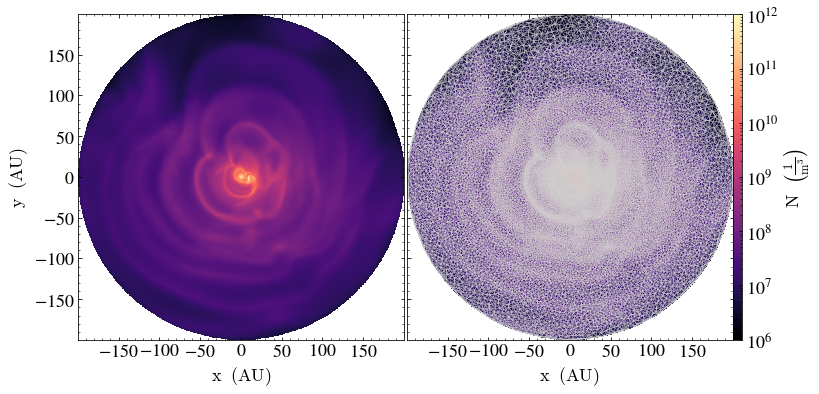

In [8]:
import matplotlib
fig=plt.figure()
grid = AxesGrid(fig, (0.100,0.075,0.85,0.85),
# grid = AxesGrid(fig, (0.100,-0.30,0.825,1.9),
                nrows_ncols = (1, 2),
                axes_pad = 0.05,
                label_mode = "L",
                share_all = True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="3%",
                cbar_pad="0%")


sl = yt.SlicePlot (ds, 'z', [('connect1', 'n')])
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.zoom(1.1)

plot = sl.plots[('connect1', 'n')]
plot.figure = fig
plot.axes = grid[0].axes
plot.cax = grid.cbar_axes[0]

# Finally, this actually redraws the plot.
sl.render()

sl = yt.SlicePlot (ds, 'z', [('connect1', 'n')])
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})

plot = sl.plots[('connect1', 'n')]
plot.figure = fig
plot.axes = grid[1].axes
plot.cax = grid.cbar_axes[1]

# Finally, this actually redraws the plot.
sl.render()

plt.savefig("wind_model_density_mesh_original.jpg", dpi = 500, bbox_inches='tight')

The mesh can also be shown seperately


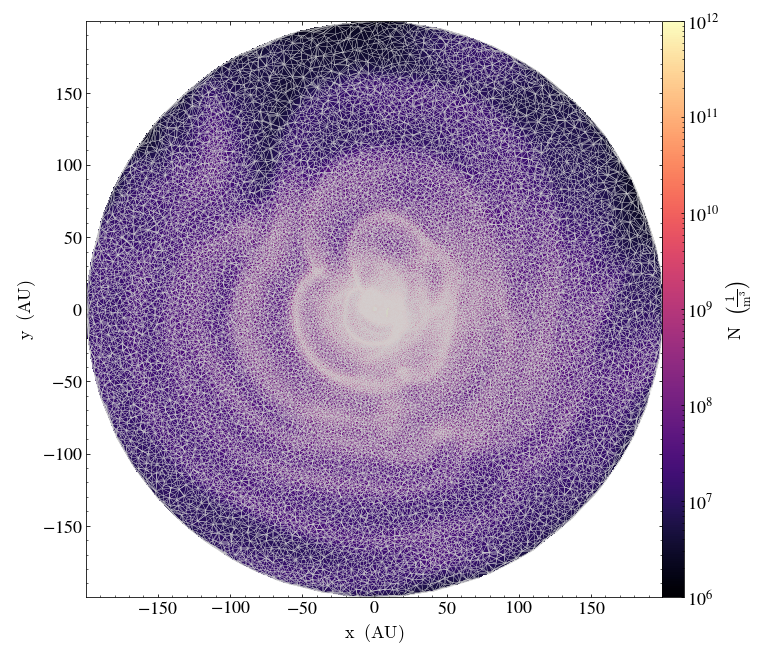

In [9]:
sl = yt.SlicePlot      (ds, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})

# Reducing the model (in two different ways)

In [10]:
import magritte.setup  as setup                        # Model setup
import magritte.core   as magritte                     # Core functionality
import magritte.mesher as mesher                       # Mesher
import numpy           as np                           # Data structures
import vtk                                             # Reading the model
import warnings                                        # Hide warnings
warnings.filterwarnings('ignore')                      # especially for yt
import yt                                              # 3D plotting
import os
import time                                            # For timing

from tqdm                   import tqdm                # Progress bars
from astropy                import constants           # Unit conversions
from vtk.util.numpy_support import vtk_to_numpy        # Converting data
from scipy.spatial          import Delaunay, cKDTree   # Finding neighbors
from yt.funcs               import mylog               # To avoid yt output 
mylog.setLevel(40)                                     # as error messages
from magritte.haar import Haar

First, we reduce using the old approach (using gmsh)

In [11]:
model_file = os.path.join(wdir, 'model_Phantom_3D.hdf5')   # Original Magritte model
lamda_file = os.path.join(wdir, 'co.txt'               )   # Line data file
redux_file = os.path.join(wdir, 'wind_red' )   # Reduced Magritte model (no extension, as this will be split into 2 different possibilities!)
print(redux_file)

/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red


In [12]:
model = magritte.Model(model_file)

                                           
-------------------------------------------
  Reading Model...                         
-------------------------------------------
 model file = /lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/model_Phantom_3D.hdf5
-------------------------------------------
Reading parameters...
Reading points...
Reading rays...
Reading boundary...
Reading chemistry...
Reading species...
Reading thermodynamics...
Reading temperature...
Reading turbulence...
Reading lines...
Reading lineProducingSpecies...
Reading linedata...
read num 1
read sym CO
nlev = 41
nrad = 1
Reading collisionPartner...
Reading collisionPartner...
Reading quadrature...
Reading radiation...
Reading frequencies...
Not using scattering!
                                           
-------------------------------------------
  Model read, parameters:                  
-------------------------------------------
  npoints    = 1138669
  nrays      = 108
  nboundary  = 32310
  nf

Extract the data from the model

In [13]:
position = np.array(model.geometry.points.position)
velocity = np.array(model.geometry.points.velocity)
boundary = np.array(model.geometry.boundary.boundary2point)
nCO      = np.array(model.chemistry.species.abundance)[:,1]
nH2      = np.array(model.chemistry.species.abundance)[:,2]
tmp      = np.array(model.thermodynamics.temperature.gas)
trb      = np.array(model.thermodynamics.turbulence.vturb2)

Remesh using delaunay -> gmsh; this can take a few minutes
First we create a delaunay mesh for the original points, then we define a spherical boundary for the model and finally, we reduce the model taking into account the CO distribution.

In [14]:
#entire GMSH remesh procedure time

start = time.time()

delaunay = Delaunay(position)
r_bdy = 0.99 * np.min(np.linalg.norm(position[boundary], axis=1))
boundary_reduced = mesher.boundary_sphere(radius = r_bdy)
#%%capture
mesher.reduce(
    meshName  = redux_file,         # Name for reduced model
    delaunay  = delaunay,           # Delaunay object of original mesh
    tracer    = nCO,                # Tracer to optimise for sampling for
    boundary  = boundary_reduced,   # Boundary of reduced mesh
    scale_max = 1.0e+99,            # Maximum scale parameter
    scale_min = 0.0e+00,            # Minimum scale parameter
    threshold = 0.21,               # Threashold rel. diff. for coarsening
    fmin      = 1.0,                # Don't allow refinenment 
    ftarget   = 2.15                # 10^(-1/3) for approx 10x fewer points
)
#%%capture
mesh = mesher.Mesh(f'{redux_file}.vtk')

end = time.time()
print("GMSH remeshing time: ", end - start)


Info    : Running 'gmsh -0 /lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red_convert_to_pos.geo' [Gmsh 4.7.1, 1 node, max. 1 thread]
Info    : Started on Tue Mar  7 14:08:31 2023
Info    : Reading '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red_convert_to_pos.geo'...
Info    : Reading '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red.msh'...
Info    : 1138669 nodes
Info    : [  0%] Creating discrete volume 0
Info    : 7653411 elements                                              
Info    : Done reading '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red.msh'
Info    : Writing '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red.pos'...


Info    : Done writing '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red.pos'
Info    : Done reading '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red_convert_to_pos.geo'
Info    : Writing '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red_convert_to_pos.geo_unrolled'...
Info    : Done writing '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red_convert_to_pos.geo_unrolled'
Info    : Stopped on Tue Mar  7 14:09:17 2023 (From start: Wall 46.403s, CPU 45.1641s)
Info    : Running 'gmsh /lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red.geo -3 -saveall -o /lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red.vtk' [Gmsh 4.7.1, 1 node, max. 1 thread]
Info    : Started on Tue Mar  7 14:09:18 2023
Info    : Reading '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red.geo'...
Info    : Reading '/lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red.pos'...
Info    

We load the reduced mesh

In [15]:
%%capture
mesh = mesher.Mesh(f'{redux_file}.vtk')

Haar wavelet based remeshing method (unfortunately, numba jit influences the runtimes, so one might need to run this multiple times to obtain accurate results); Note: this is no longer mentioned in the paper, due to the disappointing accuracy on the resulting mesh.

In [16]:
import time

start = time.time()



haar_points, nb_boundary_haar = Haar.remesh(position, nCO, threshold=3.0e-2, q=10)
nb_bulk = len(haar_points) - nb_boundary_haar
print("number bulk points: ", nb_bulk)
print("number boundary points: ", nb_boundary_haar)
#first nb_boundary points are then the boundary points

end = time.time()
print("haar remeshing time: ", end - start)


number of bulk points:  87630
number of boundary points:  985
number bulk points:  87630
number boundary points:  985
haar remeshing time:  13.939943313598633


Also use the recursive mesher

In [17]:
start = time.time()
#rec_points, nb_boundary_rec = remesh_recursive(position, nCO, q = 16, threshold = 4.2e-1, hullorder = 3)
# rec_points, nb_boundary_rec = mesher.remesh_point_cloud(position, nCO, max_depth = 10, threshold = 4e-1, hullorder = 3)
rec_points, nb_boundary_rec = mesher.remesh_point_cloud(position, nCO, max_depth = 12, threshold = 4e-1, hullorder = 3)
end = time.time()
print("recursive remeshing time: ", end-start)


new interior points:  88460
number boundary points:  386
recursive remeshing time:  2.926004409790039


Compare the points in the original and reduced meshes; parameters were chosen such that the reduced grids have approximately the same number of points as the original ones.

In [18]:
npoints          = model.parameters.npoints()
npoints_reduced_gmsh  = len(mesh.points)
npoints_reduced_haar  = len(haar_points)
npoints_reduced_rec  = len(rec_points)

print('npoints original =', npoints)
print('npoints reduced gmsh =', npoints_reduced_gmsh)
print('reduction factor gmsh =', npoints/npoints_reduced_gmsh)
print('npoints reduced haar =', npoints_reduced_haar)
print('reduction factor haar =', npoints/npoints_reduced_haar)
print('npoints reduced rec =', npoints_reduced_rec)
print('reduction factor rec =', npoints/npoints_reduced_rec)


npoints original = 1138669
npoints reduced gmsh = 91960
reduction factor gmsh = 12.382220530665506
npoints reduced haar = 88615
reduction factor haar = 12.849619138971958
npoints reduced rec = 88846
reduction factor rec = 12.81621007135943


Save all models

In [19]:
# Find closest points
corresp_points_gmsh = cKDTree(position).query(mesh.points)[1]
corresp_points_haar = cKDTree(position).query(haar_points)[1]
corresp_points_rec = cKDTree(position).query(rec_points)[1]

# Map data gmsh
position_reduced_gmsh = mesh.points#position[corresp_points]
velocity_reduced_gmsh = velocity[corresp_points_gmsh]
nCO_reduced_gmsh      = nCO     [corresp_points_gmsh]
nH2_reduced_gmsh      = nH2     [corresp_points_gmsh]
tmp_reduced_gmsh      = tmp     [corresp_points_gmsh]
trb_reduced_gmsh      = trb     [corresp_points_gmsh]

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay_gmsh = Delaunay(position_reduced_gmsh)
(indptr, indices) = delaunay_gmsh.vertex_neighbor_vertices
neighbors_gmsh = [indices[indptr[k]:indptr[k+1]] for k in range(npoints_reduced_gmsh)]
nbs_gmsh       = [n for sublist in neighbors_gmsh for n in sublist]
n_nbs_gmsh     = [len(sublist) for sublist in neighbors_gmsh]

# Convenience arrays
zeros_gmsh = np.zeros(npoints_reduced_gmsh)
ones_gmsh  = np.ones (npoints_reduced_gmsh)

#same for haar reduction

position_reduced_haar = haar_points#position[corresp_points]
velocity_reduced_haar = velocity[corresp_points_haar]
nCO_reduced_haar      = nCO     [corresp_points_haar]
nH2_reduced_haar      = nH2     [corresp_points_haar]
tmp_reduced_haar      = tmp     [corresp_points_haar]
trb_reduced_haar      = trb     [corresp_points_haar]

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay_haar = Delaunay(position_reduced_haar)
(indptr, indices) = delaunay_haar.vertex_neighbor_vertices
neighbors_haar = [indices[indptr[k]:indptr[k+1]] for k in range(npoints_reduced_haar)]
nbs_haar       = [n for sublist in neighbors_haar for n in sublist]
n_nbs_haar     = [len(sublist) for sublist in neighbors_haar]

# Convenience arrays
zeros_haar = np.zeros(npoints_reduced_haar)
ones_haar  = np.ones (npoints_reduced_haar)

#also same for recursive

position_reduced_rec = rec_points#position[corresp_points]
velocity_reduced_rec = velocity[corresp_points_rec]
nCO_reduced_rec      = nCO     [corresp_points_rec]
nH2_reduced_rec      = nH2     [corresp_points_rec]
tmp_reduced_rec      = tmp     [corresp_points_rec]
trb_reduced_rec      = trb     [corresp_points_rec]

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay_rec = Delaunay(position_reduced_rec)
(indptr, indices) = delaunay_rec.vertex_neighbor_vertices
neighbors_rec = [indices[indptr[k]:indptr[k+1]] for k in range(npoints_reduced_rec)]
nbs_rec       = [n for sublist in neighbors_rec for n in sublist]
n_nbs_rec     = [len(sublist) for sublist in neighbors_rec]

# Convenience arrays
zeros_rec = np.zeros(npoints_reduced_rec)
ones_rec  = np.ones (npoints_reduced_rec)

Write gmsh model

In [20]:
model = magritte.Model ()                                        # Create model object

model.parameters.set_model_name         (f'{redux_file}_gmsh.hdf5')   # Magritte model file
model.parameters.set_dimension          (3)                      # This is a 3D model
model.parameters.set_npoints            (npoints_reduced_gmsh)        # Number of points
model.parameters.set_nrays              (12*3**2)                      # Number of rays  
model.parameters.set_hnrays             (6*3**2)                      # Number of rays  
model.parameters.set_nspecs             (5)                      # Number of species (min. 5)
model.parameters.set_nlspecs            (1)                      # Number of line species
model.parameters.set_nfreqs             (31)
model.parameters.set_nlines             (1)
model.parameters.set_nquads             (31)                     # Number of quadrature points

model.geometry.points.position.set(position_reduced_gmsh)
model.geometry.points.velocity.set(velocity_reduced_gmsh)

model.geometry.points.  neighbors.set(  nbs_gmsh)
model.geometry.points.n_neighbors.set(n_nbs_gmsh)

model.chemistry.species.abundance = np.array((zeros_gmsh, nCO_reduced_gmsh, nH2_reduced_gmsh, zeros_gmsh, ones_gmsh)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp_reduced_gmsh)
model.thermodynamics.turbulence.vturb2.set(trb_reduced_gmsh)

model.parameters.set_nboundary(len(mesh.boundary))
model.geometry.boundary.boundary2point.set(mesh.boundary)
# model.parameters.set_nboundary(nb_boundary)
# model.geometry.boundary.boundary2point.set(np.arange(nb_boundary))

# direction = np.array([[0,0,+1], [0,0,-1]])            # Comment out to use all directions
# model.geometry.rays.direction.set(direction)          # Comment out to use all directions
# model.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

model = setup.set_uniform_rays            (model)   # Uncomment to use all directions
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


Write Haar model

In [21]:
model = magritte.Model ()                                        # Create model object

model.parameters.set_model_name         (f'{redux_file}_haar.hdf5')   # Magritte model file
model.parameters.set_dimension          (3)                      # This is a 3D model
model.parameters.set_npoints            (npoints_reduced_haar)        # Number of points
model.parameters.set_nrays              (12*3**2)                      # Number of rays  
model.parameters.set_hnrays             (6*3**2)                      # Number of rays  
model.parameters.set_nspecs             (5)                      # Number of species (min. 5)
model.parameters.set_nlspecs            (1)                      # Number of line species
model.parameters.set_nfreqs             (31)
model.parameters.set_nlines             (1)
model.parameters.set_nquads             (31)                     # Number of quadrature points

model.geometry.points.position.set(position_reduced_haar)
model.geometry.points.velocity.set(velocity_reduced_haar)

model.geometry.points.  neighbors.set(  nbs_haar)
model.geometry.points.n_neighbors.set(n_nbs_haar)

model.chemistry.species.abundance = np.array((zeros_haar, nCO_reduced_haar, nH2_reduced_haar, zeros_haar, ones_haar)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp_reduced_haar)
model.thermodynamics.turbulence.vturb2.set(trb_reduced_haar)

#haar remeshing results in the first nb_boundary points being the boundary points
model.parameters.set_nboundary(nb_boundary_haar)
model.geometry.boundary.boundary2point.set(np.arange(nb_boundary_haar))

# direction = np.array([[0,0,+1], [0,0,-1]])            # Comment out to use all directions
# model.geometry.rays.direction.set(direction)          # Comment out to use all directions
# model.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

model = setup.set_uniform_rays            (model)   # Uncomment to use all directions
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


Write recursive model

In [22]:
model = magritte.Model ()                                        # Create model object

model.parameters.set_model_name         (f'{redux_file}_rec.hdf5')   # Magritte model file
model.parameters.set_dimension          (3)                      # This is a 3D model
model.parameters.set_npoints            (npoints_reduced_rec)        # Number of points
model.parameters.set_nrays              (12*3**2)                      # Number of rays  
model.parameters.set_hnrays             (6*3**2)                      # Number of rays  
model.parameters.set_nspecs             (5)                      # Number of species (min. 5)
model.parameters.set_nlspecs            (1)                      # Number of line species
model.parameters.set_nfreqs             (31)
model.parameters.set_nlines             (1)
model.parameters.set_nquads             (31)                     # Number of quadrature points

model.geometry.points.position.set(position_reduced_rec)
model.geometry.points.velocity.set(velocity_reduced_rec)

model.geometry.points.  neighbors.set(  nbs_rec)
model.geometry.points.n_neighbors.set(n_nbs_rec)

model.chemistry.species.abundance = np.array((zeros_rec, nCO_reduced_rec, nH2_reduced_rec, zeros_rec, ones_rec)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp_reduced_rec)
model.thermodynamics.turbulence.vturb2.set(trb_reduced_rec)

#recursive remeshing results in the first nb_boundary points being the boundary points
model.parameters.set_nboundary(nb_boundary_rec)
model.geometry.boundary.boundary2point.set(np.arange(nb_boundary_rec))

# direction = np.array([[0,0,+1], [0,0,-1]])            # Comment out to use all directions
# model.geometry.rays.direction.set(direction)          # Comment out to use all directions
# model.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

model = setup.set_uniform_rays            (model)   # Uncomment to use all directions
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


# Plot reduced models

In [23]:
model_gmsh = magritte.Model(f'{redux_file}_gmsh.hdf5')
position_reduced_gmsh = np.array(model_gmsh.geometry.points.position)

                                           
-------------------------------------------
  Reading Model...                         
-------------------------------------------
 model file = /lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red_gmsh.hdf5
-------------------------------------------
Reading parameters...
Reading points...
Reading rays...
Reading boundary...
Reading chemistry...
Reading species...
Reading thermodynamics...
Reading temperature...
Reading turbulence...
Reading lines...
Reading lineProducingSpecies...
Reading linedata...
read num 1
read sym CO
nlev = 41
nrad = 1
Reading collisionPartner...
Reading collisionPartner...
Reading quadrature...
Reading radiation...
Reading frequencies...
Not using scattering!
                                           
-------------------------------------------
  Model read, parameters:                  
-------------------------------------------
  npoints    = 91960
  nrays      = 108
  nboundary  = 4792
  nfreqs  

Use delaunay for plotting again

In [24]:
from scipy.spatial import Delaunay
delaunay_gmsh = Delaunay(position_reduced_gmsh)
nCO_reduced_gmsh = np.array(model_gmsh.chemistry.species.abundance)[:,1]
ds_gmsh = yt.load_unstructured_mesh(
         connectivity = delaunay_gmsh.simplices.astype(np.int64),
         coordinates  = delaunay_gmsh.points.astype(np.float64), # yt expects cm not m
         node_data    = {('connect1', 'n'): nCO_reduced_gmsh[delaunay_gmsh.simplices].astype(np.float64)/yt.units.m**3},
         length_unit='m'
)

Slice plot (orthogonal to z-axis)

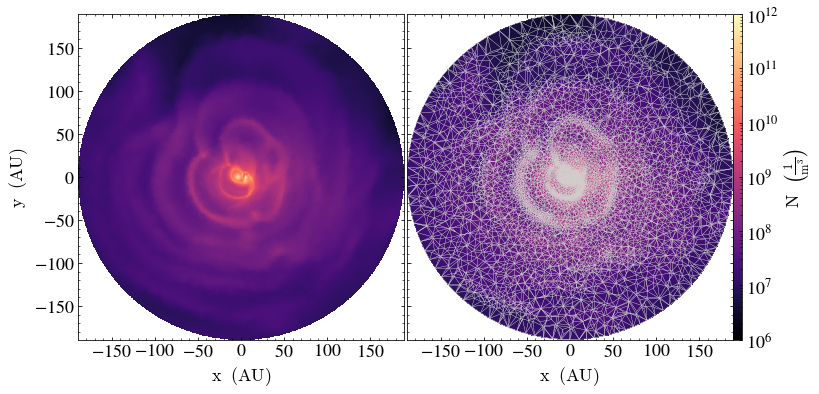

In [25]:
fig=plt.figure()
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (1, 2),
                axes_pad = 0.05,
                label_mode = "L",
                share_all = True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="3%",
                cbar_pad="0%")

sl = yt.SlicePlot (ds_gmsh, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.zoom           (1.1)

plot = sl.plots[('connect1', 'n')]
plot.figure = fig
plot.axes = grid[0].axes
plot.cax = grid.cbar_axes[0]

# Finally, this actually redraws the plot.
sl.render()

sl = yt.SlicePlot      (ds_gmsh, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})


plot = sl.plots[('connect1', 'n')]
plot.figure = fig
plot.axes = grid[1].axes
plot.cax = grid.cbar_axes[1]

# # Finally, this actually redraws the plot.
sl.render()
plt.savefig("wind_model_density_mesh_gmsh.jpg", dpi = 500, bbox_inches='tight')

Similarly, the mesh can also be shown


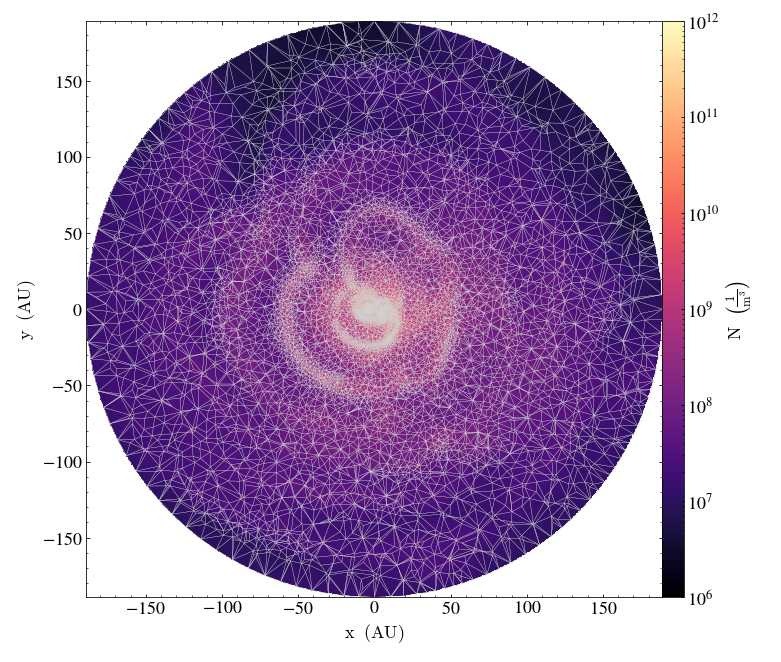

In [26]:
sl = yt.SlicePlot      (ds_gmsh, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})

Same for haar remeshed models

In [27]:
model_haar = magritte.Model(f'{redux_file}_haar.hdf5')
position_reduced_haar = np.array(model_haar.geometry.points.position)

                                           
-------------------------------------------
  Reading Model...                         
-------------------------------------------
 model file = /lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red_haar.hdf5
-------------------------------------------
Reading parameters...
Reading points...
Reading rays...
Reading boundary...
Reading chemistry...
Reading species...
Reading thermodynamics...
Reading temperature...
Reading turbulence...
Reading lines...
Reading lineProducingSpecies...
Reading linedata...
read num 1
read sym CO
nlev = 41
nrad = 1
Reading collisionPartner...
Reading collisionPartner...
Reading quadrature...
Reading radiation...
Reading frequencies...
Not using scattering!
                                           
-------------------------------------------
  Model read, parameters:                  
-------------------------------------------
  npoints    = 88615
  nrays      = 108
  nboundary  = 985
  nfreqs   

In [28]:
delaunay_haar = Delaunay(position_reduced_haar)
nCO_reduced_haar = np.array(model_haar.chemistry.species.abundance)[:,1]
ds_haar = yt.load_unstructured_mesh(
         connectivity = delaunay_haar.simplices.astype(np.int64),
         coordinates  = delaunay_haar.points.astype(np.float64) * 100.0, # yt expects cm not m
         node_data    = {('connect1', 'n'): nCO_reduced_haar[delaunay_haar.simplices].astype(np.float64)/ yt.units.m**3}
)

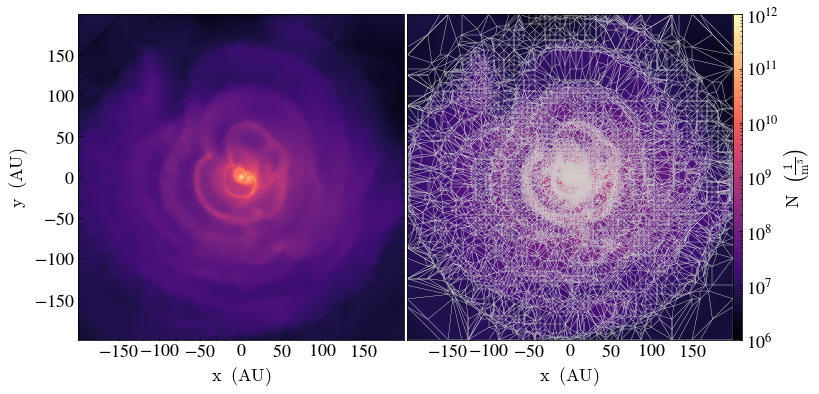

In [29]:
fig=plt.figure()
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (1, 2),
                axes_pad = 0.05,
                label_mode = "L",
                share_all = True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="3%",
                cbar_pad="0%")

sl = yt.SlicePlot (ds_haar, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.zoom           (1.1)

plot = sl.plots[('connect1', 'n')]
plot.figure = fig
plot.axes = grid[0].axes
plot.cax = grid.cbar_axes[0]

# Finally, this actually redraws the plot.
sl.render()

sl = yt.SlicePlot      (ds_haar, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})


plot = sl.plots[('connect1', 'n')]
plot.figure = fig
plot.axes = grid[1].axes
plot.cax = grid.cbar_axes[1]

# # Finally, this actually redraws the plot.
sl.render()
plt.savefig("wind_model_density_mesh_haar.jpg", dpi = 500, bbox_inches='tight')


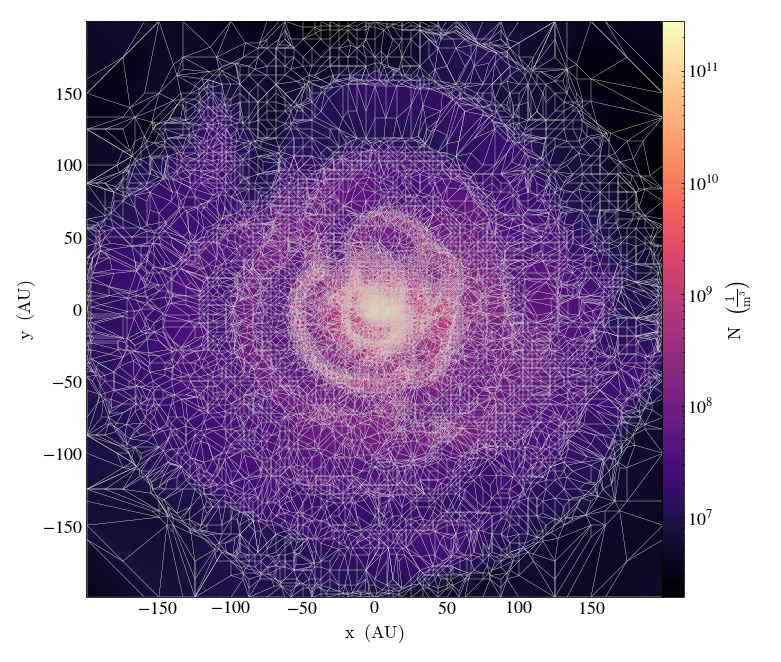

In [30]:
sl = yt.SlicePlot      (ds_haar, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})

And also the same for the recursive meshing

In [31]:
model_rec = magritte.Model(f'{redux_file}_rec.hdf5')
position_reduced_rec = np.array(model_rec.geometry.points.position)

                                           
-------------------------------------------
  Reading Model...                         
-------------------------------------------
 model file = /lhome/thomasc/Magritte-examples/Magritte3paper/Phantom_3D/wind_red_rec.hdf5
-------------------------------------------
Reading parameters...
Reading points...
Reading rays...
Reading boundary...
Reading chemistry...
Reading species...
Reading thermodynamics...
Reading temperature...
Reading turbulence...
Reading lines...
Reading lineProducingSpecies...
Reading linedata...
read num 1
read sym CO
nlev = 41
nrad = 1
Reading collisionPartner...
Reading collisionPartner...
Reading quadrature...
Reading radiation...
Reading frequencies...
Not using scattering!
                                           
-------------------------------------------
  Model read, parameters:                  
-------------------------------------------
  npoints    = 88846
  nrays      = 108
  nboundary  = 386
  nfreqs    

In [32]:
delaunay_rec = Delaunay(position_reduced_rec)
nCO_reduced_rec = np.array(model_rec.chemistry.species.abundance)[:,1]
ds_rec = yt.load_unstructured_mesh(
         connectivity = delaunay_rec.simplices.astype(np.int64),
         coordinates  = delaunay_rec.points.astype(np.float64) * 100.0, # yt expects cm not m
         node_data    = {('connect1', 'n'): nCO_reduced_rec[delaunay_rec.simplices].astype(np.float64)/ yt.units.m**3}
)

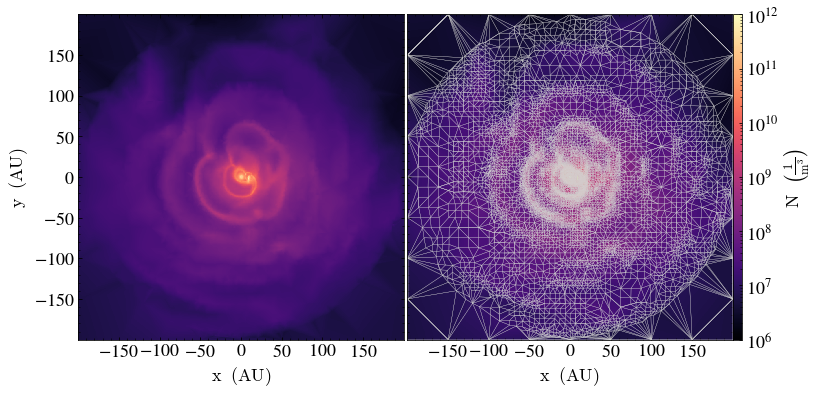

In [33]:
fig=plt.figure()
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (1, 2),
                axes_pad = 0.05,
                label_mode = "L",
                share_all = True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="3%",
                cbar_pad="0%")

sl = yt.SlicePlot (ds_rec, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.zoom           (1.1)

plot = sl.plots[('connect1', 'n')]
plot.figure = fig
plot.axes = grid[0].axes
plot.cax = grid.cbar_axes[0]

# Finally, this actually redraws the plot.
sl.render()

sl = yt.SlicePlot      (ds_rec, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})


plot = sl.plots[('connect1', 'n')]
plot.figure = fig
plot.axes = grid[1].axes
plot.cax = grid.cbar_axes[1]

# # Finally, this actually redraws the plot.
sl.render()
plt.savefig("wind_model_density_mesh_rec.jpg", dpi = 500, bbox_inches='tight')


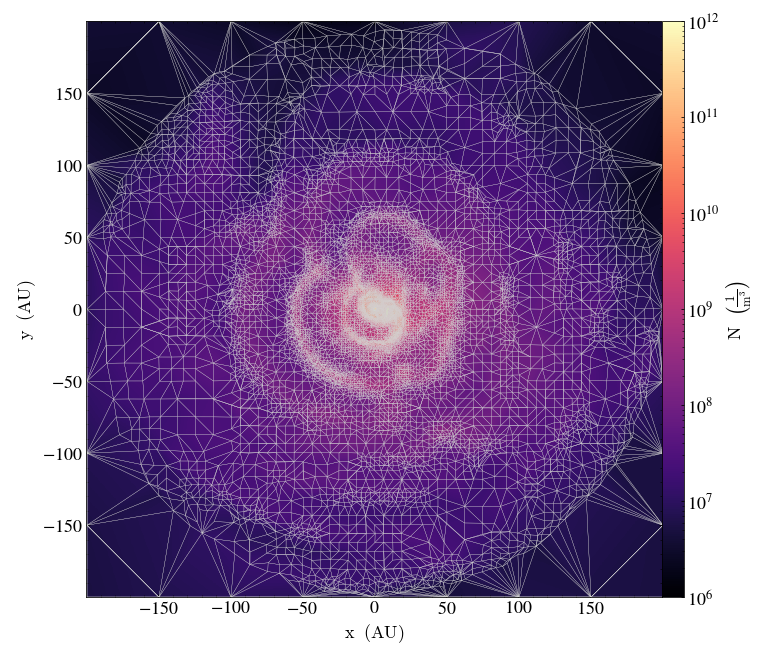

In [34]:
sl = yt.SlicePlot      (ds_rec, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.set_zlim(('connect1', 'n'), zmin=(1e+6, 'm**(-3)'), zmax=(1e+12, 'm**(-3)'))
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})